# Retail Saarthi SLM 

- This notebook contains us making a custom SLM for our final year Project 

## Step 1 : Load the Dataset 

In [1]:
import pandas as pd
from datasets import Dataset, DatasetDict

# 1. Define your file list based on the uploaded files
file_paths = [
    "SLM Training Dataset/Identity Dataset.csv",
    "SLM Training Dataset/Retail Term web dataset.csv",
    "SLM Training Dataset/Govt Act Data.csv",
    "SLM Training Dataset/Retail Comperhensive dataset.csv",
    "SLM Training Dataset/Audio Dataset.csv"
]

all_texts = []

# Define a simple template
for file_path in file_paths:
    try:
        df = pd.read_csv(file_path)
        if 'text' in df.columns:
            # If it's the Identity or Govt Act file, use a Question-Answer format
            if "Identity" in file_path or "Govt" in file_path:
                for val in df['text'].dropna():
                    formatted_text = f"User: Who are you?\nAssistant: {val}<|endoftext|>\n"
                    all_texts.append(formatted_text)
            else:
                # For general retail terms, provide a generic prompt
                for val in df['text'].dropna():
                    formatted_text = f"User: Explain this retail concept.\nAssistant: {val}<|endoftext|>\n"
                    all_texts.append(formatted_text)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# IMPORTANT: Duplicate the Identity data so the model prioritizes its Persona
identity_df = pd.read_csv("SLM Training Dataset/Identity Dataset.csv")
for val in identity_df['text'].dropna():
    # Adding it multiple times gives it more 'weight' in a small dataset
    all_texts.append(f"User: Who are you?\nAssistant: {val}<|endoftext|>\n")
    all_texts.append(f"User: Who are you?\nAssistant: {val}<|endoftext|>\n")

print(f"Total examples with templates: {len(all_texts)}")

# 3. Create a Hugging Face Dataset
full_dataset = Dataset.from_dict({"text": all_texts})

# 4. Split into Train (80%) and Validation (20%) sets
# We use a seed for reproducibility
split_dataset = full_dataset.train_test_split(test_size=0.2, seed=42)

# 5. Rename 'test' to 'validation' to match the notebook's expected structure
ds = DatasetDict({
    'train': split_dataset['train'],
    'validation': split_dataset['test']
})

print("Dataset ready for tokenization:")
print(ds)

c:\Users\adhis\OneDrive\Desktop\Retail-Saarthi-SLM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total examples with templates: 5387
Dataset ready for tokenization:
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 4309
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1078
    })
})


## Step 2 : Tokenize the dataset 

In [22]:
import os 
import tiktoken
import numpy as np
from tqdm.auto import tqdm

# We will be using the 'gpt2' BPE tokenizer for this step as it is industry standard and mentioned in our reference [TinyStories Paper]

tokenizer = tiktoken.get_encoding("gpt2")

# --- UPDATE IN STEP 2 ---
def process(example,tokenizer):
    # Use allowed_special to recognize the endoftext token
    ids = tokenizer.encode_ordinary(example['text'])
    out = {'ids': ids, 'len': len(ids)}
    return out

#Apply the processing function to the entire dataset
print("Tokenizing the dataset...")
tokenized=ds.map(
    process,
    remove_columns=['text'],
    desc="Running tokenizer on dataset",
    num_proc=4,
    fn_kwargs={"tokenizer": tokenizer},
)

for split,dset in tokenized.items():
    arr_len = np.sum(dset['len'],dtype=np.uint64)
    filename = f'{split}.bin'

    dtype = np.uint16 ## As gpt2 bpe tokenizer has a vocab size of 50257, uint16 can easily accomodate it.

    # Create a memory-mapped array on disk
    arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))

    # To accomodate our small dataset [Temporary]
    total_batches = min(1024, len(dset)) 
    if total_batches < 1:
        total_batches = 1

    idx = 0
    
    print(f"Writing {filename}...")
    for batch_idx in tqdm(range(total_batches), desc=f'Writing {filename}'):
        # Batch together samples for faster write
        batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
        arr_batch = np.concatenate(batch['ids'])
        
        # Write into mmap
        arr[idx : idx + len(arr_batch)] = arr_batch
        idx += len(arr_batch)
    
    # Flush changes to disk
    arr.flush()
    print(f"Saved {filename} with {arr_len} tokens.")



Tokenizing the dataset...


Running tokenizer on dataset (num_proc=4): 100%|██████████| 1078/1078 [00:07<00:00, 152.55 examples/s]


Writing train.bin...


Writing train.bin: 100%|██████████| 1024/1024 [00:02<00:00, 453.70it/s]


Saved train.bin with 370030 tokens.
Writing validation.bin...


Writing validation.bin: 100%|██████████| 1024/1024 [00:01<00:00, 760.59it/s]

Saved validation.bin with 93706 tokens.


## STEP 3 - Creating input output Pairs 

In [23]:
import torch
import numpy as np 

# Config 
BATCH_SIZE = 32
BLOCK_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
device_type = 'cuda' if DEVICE == 'cuda' else 'cpu'

print(f"Device: {DEVICE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Block Size: {BLOCK_SIZE}")

def get_batch(split):
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    
    ix = torch.randint(len(data)-BLOCK_SIZE, (BATCH_SIZE,))
    x = torch.stack([torch.from_numpy((data[i:i+BLOCK_SIZE]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+BLOCK_SIZE+1]).astype(np.int64)) for i in ix])

    if device_type == 'cuda':
        x,y = x.pin_memory().to(DEVICE, non_blocking=True), y.pin_memory().to(DEVICE, non_blocking=True) 
    else:
        x,y = x.to(DEVICE), y.to(DEVICE)
    return x,y   

Device: cuda
Batch Size: 32
Block Size: 128


# Step 4 : Define SLM Architecture

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self,ndim,bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim)) #STD = 1
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None # Mean = 0
    def forward(self,x):
        return F.layer_norm(x,self.weight.shape,self.weight,self.bias,1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd,3*config.n_embd,bias=config.bias) #Projection layer 768 -> 3*768 (for q,k,v)
        self.c_proj = nn.Linear(config.n_embd,config.n_embd,bias=config.bias) # Output projection layer
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F,'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))
        
    def forward(self,x):
            B,T,C = x.size()
            q,k,v = self.c_attn(x).split(self.n_embd, dim=2)
            q = q.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
            k = k.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
            v = v.view(B,T,self.n_head,C//self.n_head).transpose(1,2)

            if self.flash:
                y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
            else :
                att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
                att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
                att = F.softmax(att, dim=-1)
                att = self.attn_dropout(att)
                y = att @ v

            y = y.transpose(1, 2).contiguous().view(B, T, C)
            y = self.resid_dropout(self.c_proj(y))
            return y
        
class MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self,x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))    


class Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp =MLP(config)
    
    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True


class GPT(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            tok_emb = nn.Embedding(config.vocab_size, config.n_embd),
            pos_emb = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.tok_emb.weight = self.lm_head.weight # Weight tying

        self.apply(self._init_weights)
        for pn,p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))
        
    def _init_weights(self,module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.tok_emb(idx)
        pos_emb = self.transformer.pos_emb(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [27]:
# DEFINE YOUR CONFIGURATION HERE
config = GPTConfig(
    vocab_size=50257,     # use the tokenizer's vocab size
    block_size=128,       # or whatever context size you're training with
    n_layer=8,
    n_head=8,
    n_embd=128,
    dropout=0.2,
    bias=True
)

model = GPT(config)

## STEP 5 : Training config 

In [28]:
import torch 
from contextlib import nullcontext

learning_rate = 5e-4
max_iters = 2900
warmup_steps = 100
min_lr = 5e-5
eval_iters = 200
batch_size = 32
block_size = 128

gradient_accumulation_steps = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_type = 'cuda' if device == 'cuda' else 'cpu'
print(f"Device: {device}")

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)


Device: cuda


In [29]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [30]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.amp.GradScaler(device_type, enabled=(dtype == 'float16'))

## Pre Train SLM 

In [31]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  3%|▎         | 97/2900 [00:04<02:05, 22.26it/s]c:\Users\adhis\OneDrive\Desktop\Retail-Saarthi-SLM\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  7%|▋         | 202/2900 [00:16<36:11,  1.24it/s]

Epoch 200: train loss 1.6657, val loss 1.7083
The current learning rate: 0.00050


 14%|█▍        | 403/2900 [00:33<33:18,  1.25it/s]

Epoch 400: train loss 0.5789, val loss 0.5993
The current learning rate: 0.00049


 21%|██        | 601/2900 [00:50<31:25,  1.22it/s]

Epoch 600: train loss 0.3721, val loss 0.4068
The current learning rate: 0.00047


 28%|██▊       | 802/2900 [01:07<29:01,  1.20it/s]

Epoch 800: train loss 0.3064, val loss 0.3416
The current learning rate: 0.00043


 34%|███▍      | 1000/2900 [01:16<01:26, 21.99it/s]

Epoch 1000: train loss 0.2738, val loss 0.3099
The current learning rate: 0.00039


 41%|████▏     | 1202/2900 [01:41<23:43,  1.19it/s]

Epoch 1200: train loss 0.2514, val loss 0.2972
The current learning rate: 0.00035


 48%|████▊     | 1400/2900 [01:51<01:11, 20.88it/s]

Epoch 1400: train loss 0.2413, val loss 0.2864
The current learning rate: 0.00030


 55%|█████▌    | 1600/2900 [02:08<01:00, 21.44it/s]

Epoch 1600: train loss 0.2329, val loss 0.2863
The current learning rate: 0.00025


 62%|██████▏   | 1800/2900 [02:25<00:51, 21.26it/s]

Epoch 1800: train loss 0.2149, val loss 0.2807
The current learning rate: 0.00020


 69%|██████▉   | 2001/2900 [02:49<11:55,  1.26it/s]

Epoch 2000: train loss 0.2113, val loss 0.2794
The current learning rate: 0.00016


 76%|███████▌  | 2204/2900 [03:06<06:35,  1.76it/s]

Epoch 2200: train loss 0.2017, val loss 0.2807
The current learning rate: 0.00012


 83%|████████▎ | 2402/2900 [03:23<06:34,  1.26it/s]

Epoch 2400: train loss 0.2027, val loss 0.2733
The current learning rate: 0.00008


 90%|████████▉ | 2602/2900 [03:40<04:25,  1.12it/s]

Epoch 2600: train loss 0.1985, val loss 0.2678
The current learning rate: 0.00006


 97%|█████████▋| 2802/2900 [03:58<01:19,  1.23it/s]

Epoch 2800: train loss 0.1851, val loss 0.2775
The current learning rate: 0.00005


100%|██████████| 2900/2900 [04:02<00:00, 11.94it/s]


## Step 9: Plot the SLM Loss Function

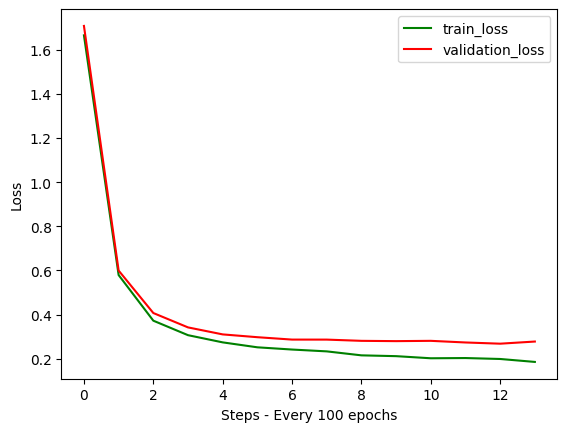

In [32]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## RUN SLM 

In [33]:
model = GPT(config)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=device))

C:\Users\adhis\AppData\Local\Temp\ipykernel_27692\3676416321.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path, map

<All keys matched successfully>

In [44]:
# --- UPDATE IN STEP 6 ---
model.eval()
user_query = "Baddd "
# Match the training template exactly
#formatted_prompt = f"User: {user_query}\nAssistant: "

start_ids = tokenizer.encode(user_query, allowed_special={'<|endoftext|>'})
context = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

with torch.no_grad():
    # Use a lower temperature (0.2-0.3) for factual identity questions
    y = model.generate(context, max_new_tokens=50, temperature=0.1)

response = tokenizer.decode(y[0].tolist())
# Extract only the assistant's new text
print(response[len(user_query):].split("<|endoftext|>")[0])

��� aapko stock clear karne mein help karunga. Main lawyer nahi hoon, par guide kar sakta hoon.
